<a href="https://colab.research.google.com/github/jason96819/Book_Rating_Regressor/blob/main/Book_data_preprocessing_%26_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이콘 도서 추천 알고리즘 AI 경진대회

사이트 : https://dacon.io/competitions/official/236093/overview/description

[주제]
도서 추천 알고리즘 AI 모델 개발



[설명]
**유저 정보(나이, 장소)**와 **도서 정보(책 제목, 책 저자, 출판 년도, 출판사)**를 바탕으로, 유저가 부여한 도서 평점을 회귀 예측하는 AI 모델을 개발해야 합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 확인

필요 라이브러리 import

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import numpy as np
import re

# 한글 폰트를 사용하기 위한 코드
path = './drive/MyDrive/data/malgun.ttf'
fontprop = fm.FontProperties(fname=path, size=10)

import warnings
warnings.simplefilter(action='ignore')

훈련 데이터 확인

In [65]:
train_df = pd.read_csv('./drive/MyDrive/data/book/train.csv')
train_df

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books
3,TRAIN_000003,USER_00000,BOOK_098622,0,23.0,"sackville, new brunswick, canada",Mother Earth Father Sky,Sue Harrison,1991.0,Avon
4,TRAIN_000004,USER_00000,BOOK_180810,8,23.0,"sackville, new brunswick, canada",She Who Remembers,Linda Lay Shuler,1989.0,Signet Book
...,...,...,...,...,...,...,...,...,...,...
871388,TRAIN_871388,USER_92096,BOOK_081138,0,34.0,"minneapolis, minnesota, usa",Healing Words: The Power of Prayer and the Pra...,Larry Dossey,1993.0,Harpercollins
871389,TRAIN_871389,USER_92097,BOOK_258124,0,35.0,"temple, texas, usa",The Salmon of Doubt: Hitchhiking the Galaxy On...,DOUGLAS ADAMS,2002.0,Harmony
871390,TRAIN_871390,USER_92098,BOOK_071848,0,45.0,"ottawa, ontario, canada",Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2000.0,Thorndike Press
871391,TRAIN_871391,USER_92099,BOOK_252599,8,43.0,"maple grove, minnesota, usa",Heartbreak Hill: Anatomy of a Ryder Cup,Tim Rosaforte,1996.0,St Martins Pr


In [66]:
train_df.isnull().sum()

ID                     0
User-ID                0
Book-ID                0
Book-Rating            0
Age                    0
Location               0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

In [67]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871393 entries, 0 to 871392
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   871393 non-null  object 
 1   User-ID              871393 non-null  object 
 2   Book-ID              871393 non-null  object 
 3   Book-Rating          871393 non-null  int64  
 4   Age                  871393 non-null  float64
 5   Location             871393 non-null  object 
 6   Book-Title           871393 non-null  object 
 7   Book-Author          871393 non-null  object 
 8   Year-Of-Publication  871393 non-null  float64
 9   Publisher            871393 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 66.5+ MB


컬럼 : 인덱스, 유저 고유 번호, 책 고유 번호, 책 점수(종속 변수), 유저 나이, 유저 지역, 책 제목, 책 저자, 출판 년도, 출판사

각 컬럼별 탐색적 분석 및 데이터 전처리

## 1. Location

Location의 나라, 주, 도시로 컬럼 3개로 확장

주의 빈칸이나 n/a가 많아 '주'는 제거

In [68]:
def remove_special(df):

    pattern = r'[^-0-9a-zA-Z,/ãåàáäâèêéëìîïíøôõöóüûúçñßæý`.()!&"^<>~*?:_¨;#¼ ]'
    selected_rows = df[df['Location'].str.contains(pattern)]
    df.drop(selected_rows.index, inplace=True)

    excla_rows = df[df['Location'].str.contains('\!')]
    df.drop(excla_rows.index, inplace=True)

    question_rows = df[df['Location'].str.contains('\?')]
    df.drop(question_rows.index, inplace=True)

    shap_rows = df[df['Location'].str.contains('\#')]
    df.drop(shap_rows.index, inplace=True)

    df.loc[[68323, 68324, 229326, 584712, 728043, 728044, 728045, 728046, 728047, 728048, 728049, 728050, 728051, 870194, 870195, 870196], 'Location'] = 'washington, n/a, usa'
    df.loc[df['Location'].str.contains('s>'), 'Location'] = 'lithia, florida, usa'
    df.loc[df['Location'].str.contains(': catalunya'), 'Location'] = 'barcelona, catalunya, spain'
    df.loc[df['Location'].str.contains('\;'), 'Location'] = 'perth, western australia, australia'

    ddang_rows = df[df['Location'].str.contains('\:')]
    df.drop(ddang_rows.index, inplace=True)

    df['Location'].str.replace(',,', ',')

    return df

In [69]:
print("전처리 하기 전 df의 길이 :", len(train_df))
pre_train_df = remove_special(train_df)
print("전처리 한 후 df의 길이 :", len(pre_train_df))

전처리 하기 전 df의 길이 : 871393
전처리 한 후 df의 길이 : 871347


In [70]:
def split_country_city(df):
    df['Location'] = [re.sub(r'[0-9"^/*~¨]',  '',str(x)) for x in df['Location']]

    df['City'] = [(city.split(',')[0]).lower() for city in df['Location']]
    df['Country'] = [(country.split(',')[2]).lstrip().lower() for country in df['Location']]

    df = df[['User-ID', 'Age', 'Country', 'City', 'Book-ID', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Book-Rating']]

    df.loc[[207, 208, 209], 'City'] = 'pisa'
    df.loc[[131847, 571734, 571735], 'Country'] = 'canada'
    df.loc[678828, 'Country'] = 'china'
    df.loc[868701, 'City'] = 'qubec'
    df.loc[870922, 'City'] = 'vancouver'

    return df

In [71]:
print("장소 전처리 전 df의 길이 :", len(pre_train_df))
split_pre_train_df = split_country_city(pre_train_df)
split_pre_train_df.loc[split_pre_train_df['City'] == 'na', 'City'] = 'Unkown'
split_pre_train_df.loc[split_pre_train_df['City'] == 'none', 'City'] = 'Unkown'
split_pre_train_df.loc[split_pre_train_df['City'] == '', 'City'] = 'Unkown'

split_pre_train_df.loc[split_pre_train_df['City'].str.contains('bennington'), 'City'] = 'bennington'
split_pre_train_df.loc[split_pre_train_df['Country'].str.contains('u.a.e'), 'Country'] = 'uae'
split_pre_train_df.loc[split_pre_train_df['Country'].str.contains('u.s.a.'), 'Country'] = 'usa'
split_pre_train_df.loc[split_pre_train_df['Country'].str.contains('u.s. of a.'), 'Country'] = 'usa'
split_pre_train_df.loc[split_pre_train_df['Country'].str.contains('l`italia'), 'Country'] = 'italy'
split_pre_train_df.loc[split_pre_train_df['Country'].str.contains('u.k.'), 'Country'] = 'united kingdom'
split_pre_train_df.loc[split_pre_train_df['Country'].str.contains('españa'), 'Country'] = 'spain'
split_pre_train_df.loc[split_pre_train_df['City'].str.contains('mississauga'), 'City'] = 'mississauga'
split_pre_train_df.loc[split_pre_train_df['City'].str.contains('busto arsizio'), 'City'] = 'busto arsizio'
split_pre_train_df.loc[split_pre_train_df['City'].str.contains('kennesaw'), 'City'] = 'kennesaw'
split_pre_train_df.loc[split_pre_train_df['City'].str.contains('barcelona'), 'City'] = 'barcelona'
split_pre_train_df.loc[split_pre_train_df['City'].str.contains('barcelona'), 'City'] = 'barcelona'
split_pre_train_df.loc[split_pre_train_df['Country'].str.contains('barcelona'), 'Country'] = 'spain'
split_pre_train_df.loc[split_pre_train_df['City'].str.contains('la garriga'), 'City'] = 'barcelona'
split_pre_train_df.loc[split_pre_train_df['City'].str.contains('oxford'), 'City'] = 'oxford'
split_pre_train_df.loc[split_pre_train_df['Country'].str.contains('elfin forest'), 'Country'] = 'usa'
split_pre_train_df.loc[split_pre_train_df['Country'].str.contains('accra'), 'Country'] = 'gaana'
split_pre_train_df.loc[split_pre_train_df['Country'].str.contains('ajijic'), 'Country'] = 'mexico'
split_pre_train_df.loc[split_pre_train_df['Country'].str.contains('choctaw'), 'Country'] = 'usa'
split_pre_train_df.loc[split_pre_train_df['Country'].str.contains('red feather lakes'), 'Country'] = 'usa'
split_pre_train_df.loc[split_pre_train_df['Country'].str.contains('popular bluff'), 'Country'] = 'usa'
split_pre_train_df.loc[split_pre_train_df['City'].str.contains('mã¼nchen'), 'City'] = 'münchen'
split_pre_train_df.loc[split_pre_train_df['City'].str.contains('neburg'), 'City'] = 'lüneburg'
split_pre_train_df.loc[400639, ['Country', 'City']] = ['germany', 'lüneburg']


pattern = r'[^-a-zãåàáäâèêéëìîïíøôõöóüûúçñßæý`.&() ]'
delete1 = split_pre_train_df[split_pre_train_df['Country'].str.contains(pattern)]
split_pre_train_df.drop(delete1.index, inplace=True)

split_pre_train_df.loc[split_pre_train_df['Country'] == '', 'Country'] = 'Unkown'

split_pre_train_df.drop(split_pre_train_df[split_pre_train_df['Country'] == 'Unkown'].index, inplace=True)
split_pre_train_df.drop(split_pre_train_df[split_pre_train_df['City'] == 'Unkown'].index, inplace=True)

split_pre_train_df['Book-Title'] = split_pre_train_df['Book-Title'].replace('&amp;', 'and', regex=True)
split_pre_train_df['Book-Author'] = split_pre_train_df['Book-Author'].replace('&amp;', 'and', regex=True)
split_pre_train_df['Publisher'] = split_pre_train_df['Publisher'].replace('&amp;', 'and', regex=True)

print("장소 전처리 한 후 df의 길이 :", len(split_pre_train_df))

장소 전처리 전 df의 길이 : 871347
장소 전처리 한 후 df의 길이 : 836041


In [72]:
train_df = split_pre_train_df.reset_index(drop=True)
train_df

,User-ID,Age,Country,City,Book-ID,Book-Title,Book-Author,Year-Of-Publication,Publisher,Book-Rating
0,USER_00000,23.0,canada,sackville,BOOK_044368,Road Taken,Rona Jaffe,2001.0,Mira,8
1,USER_00000,23.0,canada,sackville,BOOK_081205,Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books,8
2,USER_00000,23.0,canada,sackville,BOOK_086781,Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books,0
3,USER_00000,23.0,canada,sackville,BOOK_098622,Mother Earth Father Sky,Sue Harrison,1991.0,Avon,0
4,USER_00000,23.0,canada,sackville,BOOK_180810,She Who Remembers,Linda Lay Shuler,1989.0,Signet Book,8
...,...,...,...,...,...,...,...,...,...,...
836036,USER_92096,34.0,usa,minneapolis,BOOK_081138,Healing Words: The Power of Prayer and the Pra...,Larry Dossey,1993.0,Harpercollins,0
836037,USER_92097,35.0,usa,temple,BOOK_258124,The Salmon of Doubt: Hitchhiking the Galaxy On...,DOUGLAS ADAMS,2002.0,Harmony,0
836038,USER_92098,45.0,canada,ottawa,BOOK_071848,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2000.0,Thorndike Press,0
836039,USER_92099,43.0,usa,maple grove,BOOK_252599,Heartbreak Hill: Anatomy of a Ryder Cup,Tim Rosaforte,1996.0,St Martins Pr,8


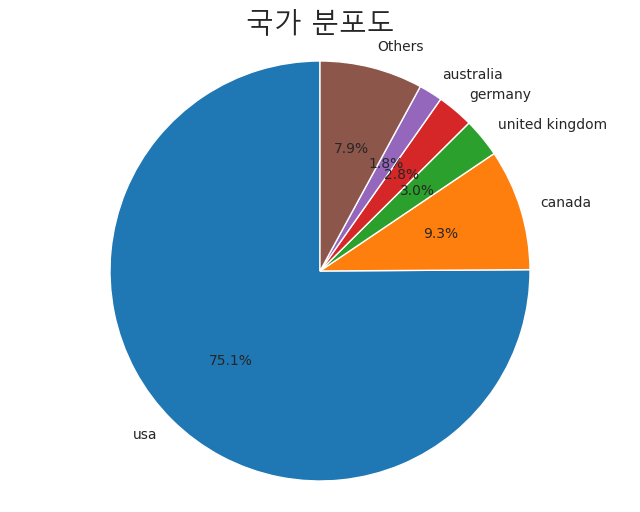

In [73]:
country_counts = train_df['Country'].value_counts()

threshold = len(train_df) * 0.015
others_count = country_counts[country_counts < threshold].sum()
country_counts_filtered = country_counts[country_counts >= threshold]
country_counts_filtered['Others'] = others_count

plt.figure(figsize=(8, 6))
plt.pie(country_counts_filtered, labels=country_counts_filtered.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('국가 분포도', fontproperties=fontprop, size=20)
plt.show()

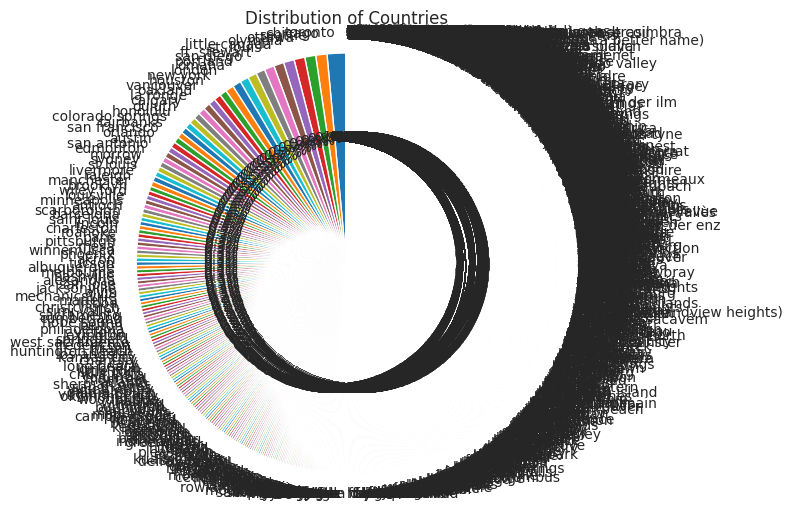

In [74]:
# 'Country' 컬럼의 값에 대한 빈도수를 구합니다.
country_counts = train_df['City'].value_counts()

# 원형 도표를 그립니다.
plt.figure(figsize=(8, 6))
plt.pie(country_counts, labels=country_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # 원형으로 표현하기 위해 가로 세로 비율을 동일하게 설정합니다.
plt.title('Distribution of Countries')
plt.show()

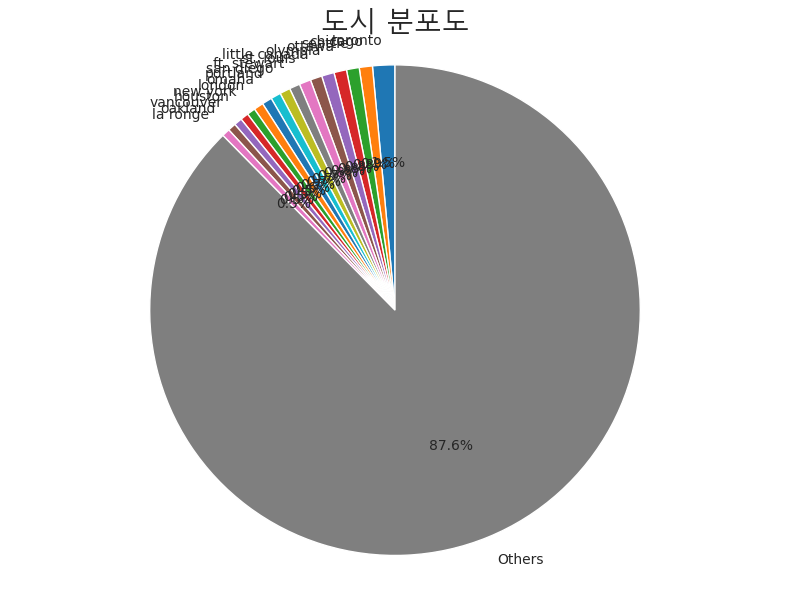

In [75]:
city_counts = train_df['City'].value_counts()

threshold = len(train_df) * 0.005
others_count = city_counts[city_counts < threshold].sum()
city_counts_filtered = city_counts[city_counts >= threshold]
city_counts_filtered['Others'] = others_count

plt.figure(figsize=(8, 6))
plt.pie(city_counts_filtered, labels=city_counts_filtered.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('도시 분포도', fontproperties=fontprop, size=20)
plt.tight_layout()
plt.show()

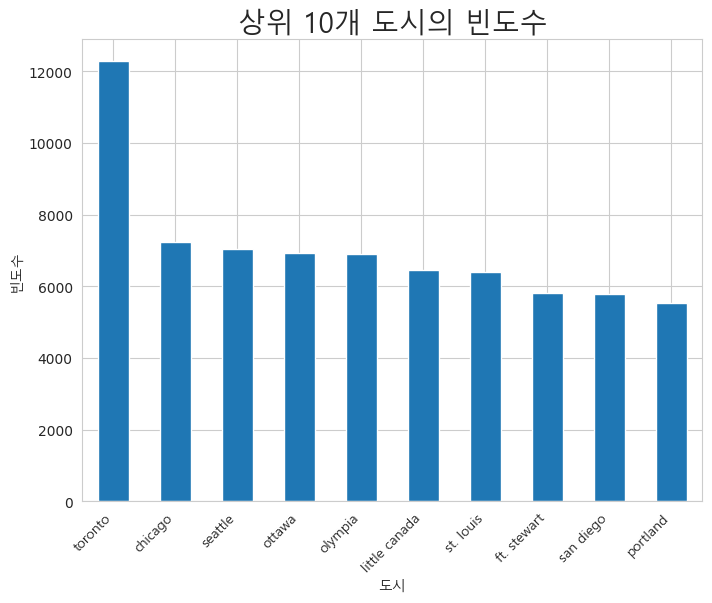

In [76]:
city_counts = train_df['City'].value_counts()
top_10_city_counts = city_counts.head(10)

plt.figure(figsize=(8, 6))
top_10_city_counts.plot(kind='bar')
plt.xticks(rotation=45, ha='right', fontproperties=fontprop)
plt.xlabel('도시', fontproperties=fontprop)
plt.ylabel('빈도수', fontproperties=fontprop)
plt.title('상위 10개 도시의 빈도수', fontproperties=fontprop, size=20)
plt.show()

## 2. Age

In [77]:
train_df

,User-ID,Age,Country,City,Book-ID,Book-Title,Book-Author,Year-Of-Publication,Publisher,Book-Rating
0,USER_00000,23.0,canada,sackville,BOOK_044368,Road Taken,Rona Jaffe,2001.0,Mira,8
1,USER_00000,23.0,canada,sackville,BOOK_081205,Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books,8
2,USER_00000,23.0,canada,sackville,BOOK_086781,Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books,0
3,USER_00000,23.0,canada,sackville,BOOK_098622,Mother Earth Father Sky,Sue Harrison,1991.0,Avon,0
4,USER_00000,23.0,canada,sackville,BOOK_180810,She Who Remembers,Linda Lay Shuler,1989.0,Signet Book,8
...,...,...,...,...,...,...,...,...,...,...
836036,USER_92096,34.0,usa,minneapolis,BOOK_081138,Healing Words: The Power of Prayer and the Pra...,Larry Dossey,1993.0,Harpercollins,0
836037,USER_92097,35.0,usa,temple,BOOK_258124,The Salmon of Doubt: Hitchhiking the Galaxy On...,DOUGLAS ADAMS,2002.0,Harmony,0
836038,USER_92098,45.0,canada,ottawa,BOOK_071848,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2000.0,Thorndike Press,0
836039,USER_92099,43.0,usa,maple grove,BOOK_252599,Heartbreak Hill: Anatomy of a Ryder Cup,Tim Rosaforte,1996.0,St Martins Pr,8


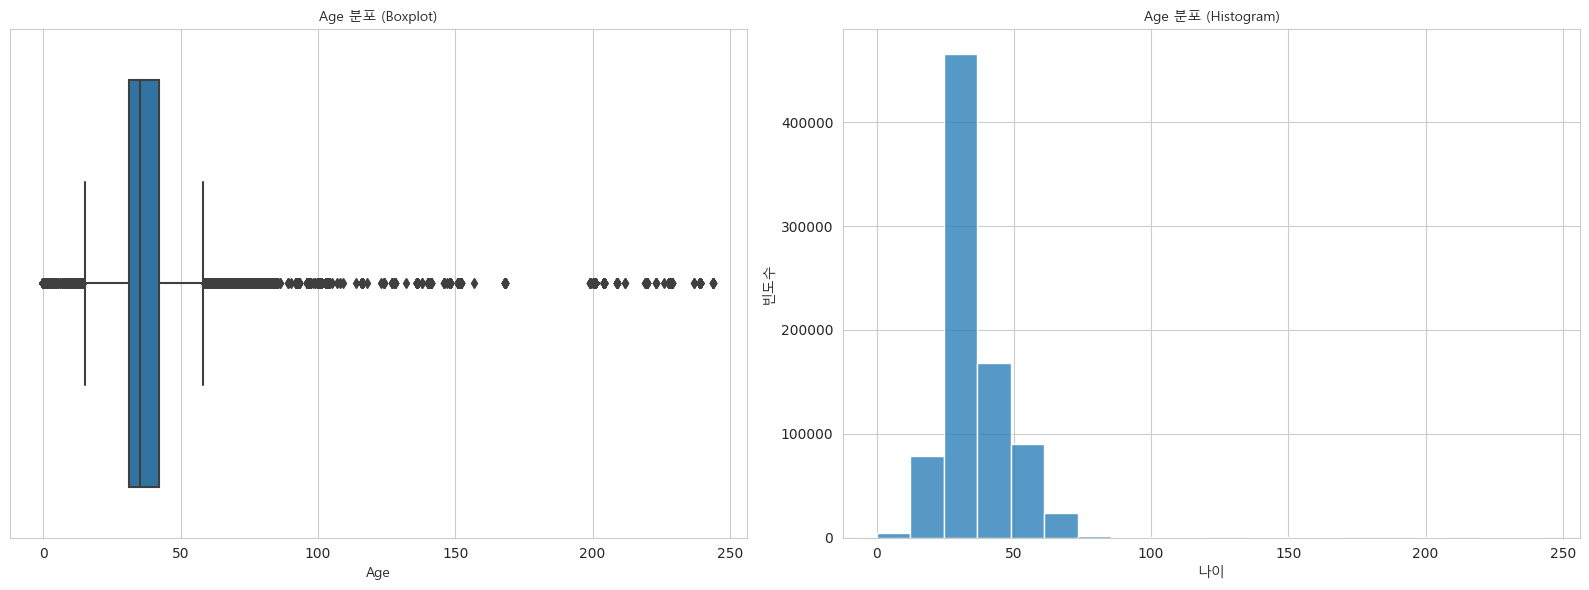

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x=train_df['Age'], ax=axes[0])
axes[0].set_xlabel('Age', fontproperties=fontprop)
axes[0].set_title('Age 분포 (Boxplot)', fontproperties=fontprop)

sns.histplot(train_df['Age'], bins=20, ax=axes[1])
axes[1].set_title('Age 분포 (Histogram)', fontproperties=fontprop)
axes[1].set_xlabel('나이', fontproperties=fontprop)
axes[1].set_ylabel('빈도수', fontproperties=fontprop)

plt.tight_layout()
plt.show()

나이는
- 6~9는 0세대
- 10~19는 10대
- 20~29는 20대 로 구간으로 표시

5세이하, 80세 초과 나이는 제거후 평균값을 대체



In [79]:
train_df.loc[train_df[train_df['Age'] < 6].index, 'Age'] = np.nan
train_df.loc[train_df[train_df['Age'] > 80].index, 'Age'] = np.nan
train_df['Age'] = train_df['Age'].fillna(np.round(train_df['Age'].mean()))

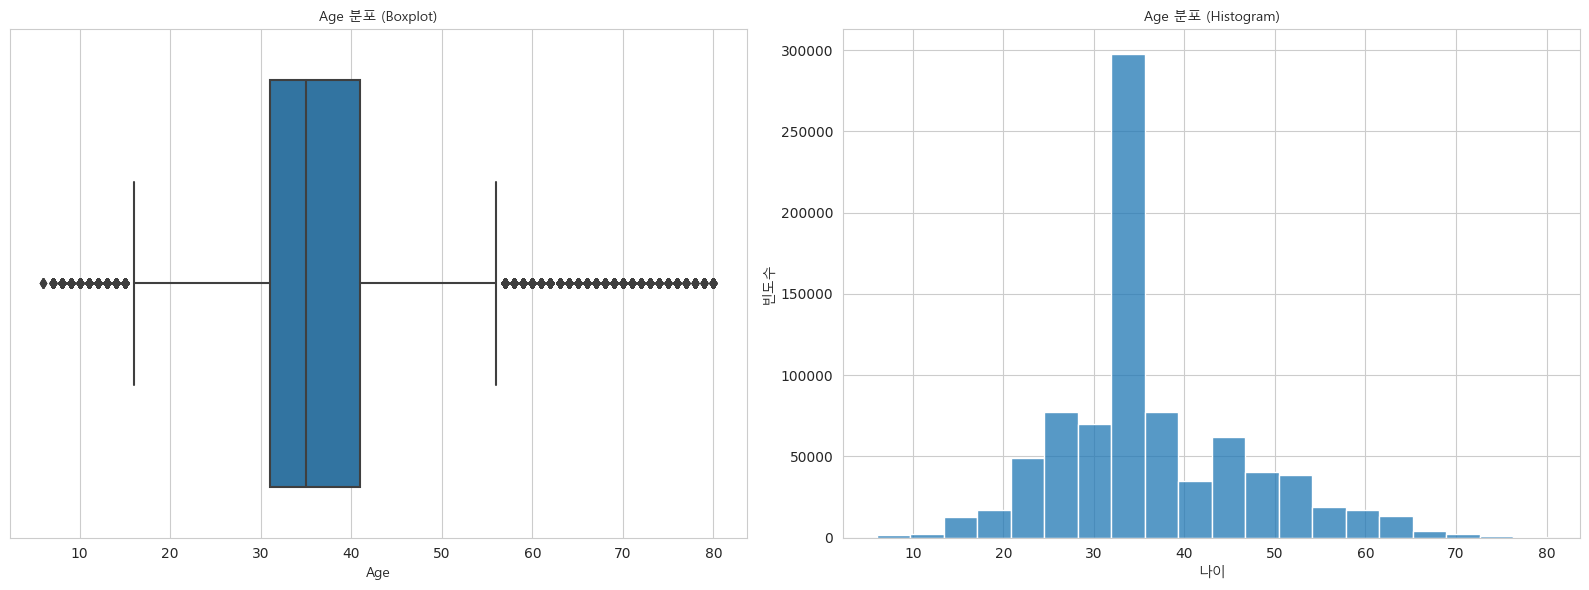

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x=train_df['Age'], ax=axes[0])
axes[0].set_xlabel('Age', fontproperties=fontprop)
axes[0].set_title('Age 분포 (Boxplot)', fontproperties=fontprop)

sns.histplot(train_df['Age'], bins=20, ax=axes[1])
axes[1].set_title('Age 분포 (Histogram)', fontproperties=fontprop)
axes[1].set_xlabel('나이', fontproperties=fontprop)
axes[1].set_ylabel('빈도수', fontproperties=fontprop)

plt.tight_layout()
plt.show()

In [81]:
train_df['Age'] = pd.cut(train_df['Age'], bins=[0, 9, 19, 29, 39, 49, 59, 69, 79, 90],
                                                            labels=[0, 10, 20, 30, 40, 50, 60, 70, 80], right=False)

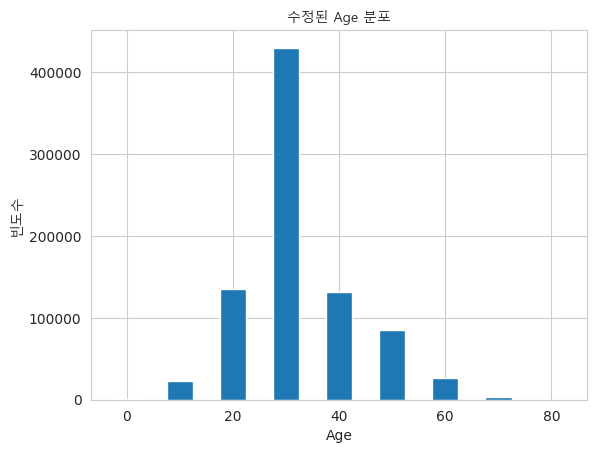

In [82]:
# 'Age' 컬럼의 빈도수를 계산합니다.
age_counts = train_df['Age'].value_counts()

# 막대 그래프를 그립니다.
plt.bar(age_counts.index, age_counts.values, width=5)
plt.xlabel('Age')
plt.ylabel('빈도수', fontproperties=fontprop)
plt.title('수정된 Age 분포', fontproperties=fontprop)
plt.show()

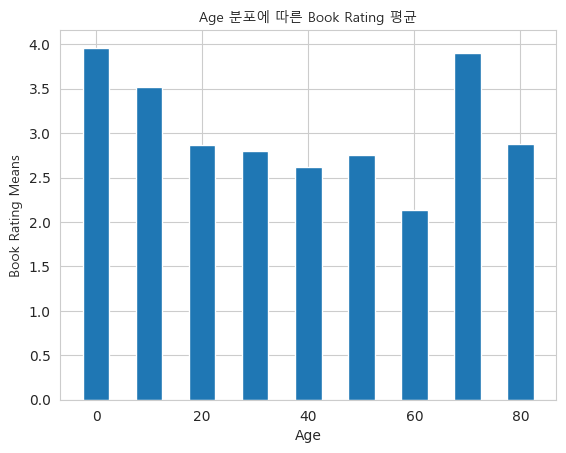

In [83]:
#나이대별 book-rating
age_counts = train_df.groupby('Age').mean()

plt.bar(age_counts.index, age_counts['Book-Rating'], width=5)
plt.xlabel('Age')
plt.ylabel('Book Rating Means', fontproperties=fontprop)
plt.title('Age 분포에 따른 Book Rating 평균', fontproperties=fontprop)
plt.show()

## 3. Book-Title

In [84]:
train_df

,User-ID,Age,Country,City,Book-ID,Book-Title,Book-Author,Year-Of-Publication,Publisher,Book-Rating
0,USER_00000,20,canada,sackville,BOOK_044368,Road Taken,Rona Jaffe,2001.0,Mira,8
1,USER_00000,20,canada,sackville,BOOK_081205,Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books,8
2,USER_00000,20,canada,sackville,BOOK_086781,Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books,0
3,USER_00000,20,canada,sackville,BOOK_098622,Mother Earth Father Sky,Sue Harrison,1991.0,Avon,0
4,USER_00000,20,canada,sackville,BOOK_180810,She Who Remembers,Linda Lay Shuler,1989.0,Signet Book,8
...,...,...,...,...,...,...,...,...,...,...
836036,USER_92096,30,usa,minneapolis,BOOK_081138,Healing Words: The Power of Prayer and the Pra...,Larry Dossey,1993.0,Harpercollins,0
836037,USER_92097,30,usa,temple,BOOK_258124,The Salmon of Doubt: Hitchhiking the Galaxy On...,DOUGLAS ADAMS,2002.0,Harmony,0
836038,USER_92098,40,canada,ottawa,BOOK_071848,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2000.0,Thorndike Press,0
836039,USER_92099,40,usa,maple grove,BOOK_252599,Heartbreak Hill: Anatomy of a Ryder Cup,Tim Rosaforte,1996.0,St Martins Pr,8


In [85]:
train_df['Book-Title'] = [re.sub(r'[^0-9a-zA-Z,.]',  ' ',str(i)) for i in train_df['Book-Title']]
train_df['Main-Title'] = [i.split('  ')[0] for i in train_df['Book-Title']]
train_df['Sub-Title'] = [''.join(i.split('  ')[1:]) for i in train_df['Book-Title']]
train_df['Sub-Title'] = np.where(train_df['Sub-Title'] == '', 'No_SUB', train_df['Sub-Title'])

In [86]:
train_df = train_df[['User-ID', 'Age', 'Country', 'City', 'Book-ID', 'Main-Title', 'Sub-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Book-Rating']]
train_df

,User-ID,Age,Country,City,Book-ID,Main-Title,Sub-Title,Book-Author,Year-Of-Publication,Publisher,Book-Rating
0,USER_00000,20,canada,sackville,BOOK_044368,Road Taken,No_SUB,Rona Jaffe,2001.0,Mira,8
1,USER_00000,20,canada,sackville,BOOK_081205,Macbeth,New Penguin Shakespeare,William Shakespeare,1981.0,Penguin Books,8
2,USER_00000,20,canada,sackville,BOOK_086781,Waverley,Penguin English Library,Walter Scott,1981.0,Penguin Books,0
3,USER_00000,20,canada,sackville,BOOK_098622,Mother Earth Father Sky,No_SUB,Sue Harrison,1991.0,Avon,0
4,USER_00000,20,canada,sackville,BOOK_180810,She Who Remembers,No_SUB,Linda Lay Shuler,1989.0,Signet Book,8
...,...,...,...,...,...,...,...,...,...,...,...
836036,USER_92096,30,usa,minneapolis,BOOK_081138,Healing Words,The Power of Prayer and the Practice of Medicine,Larry Dossey,1993.0,Harpercollins,0
836037,USER_92097,30,usa,temple,BOOK_258124,The Salmon of Doubt,Hitchhiking the Galaxy One Last Time,DOUGLAS ADAMS,2002.0,Harmony,0
836038,USER_92098,40,canada,ottawa,BOOK_071848,Harry Potter and the Prisoner of Azkaban,Book 3,J. K. Rowling,2000.0,Thorndike Press,0
836039,USER_92099,40,usa,maple grove,BOOK_252599,Heartbreak Hill,Anatomy of a Ryder Cup,Tim Rosaforte,1996.0,St Martins Pr,8


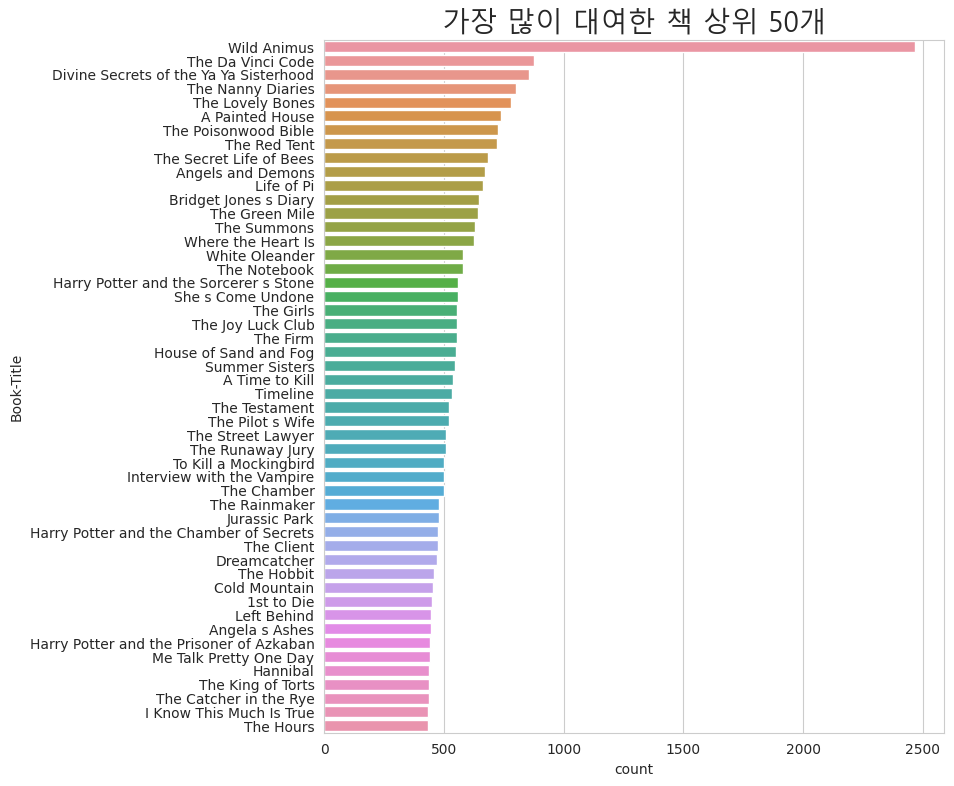

In [87]:
ds = train_df['Main-Title'].value_counts().reset_index()
ds.columns = ['Main-Title', 'count']
ds = ds.sort_values('count', ascending=False).head(50)

plt.figure(figsize=(8, 9))
sns.barplot(data=ds, x='count', y='Main-Title')
plt.title('가장 많이 대여한 책 상위 50개', fontproperties=fontprop, size=20)
plt.xlabel('count')
plt.ylabel('Book-Title')
plt.show()

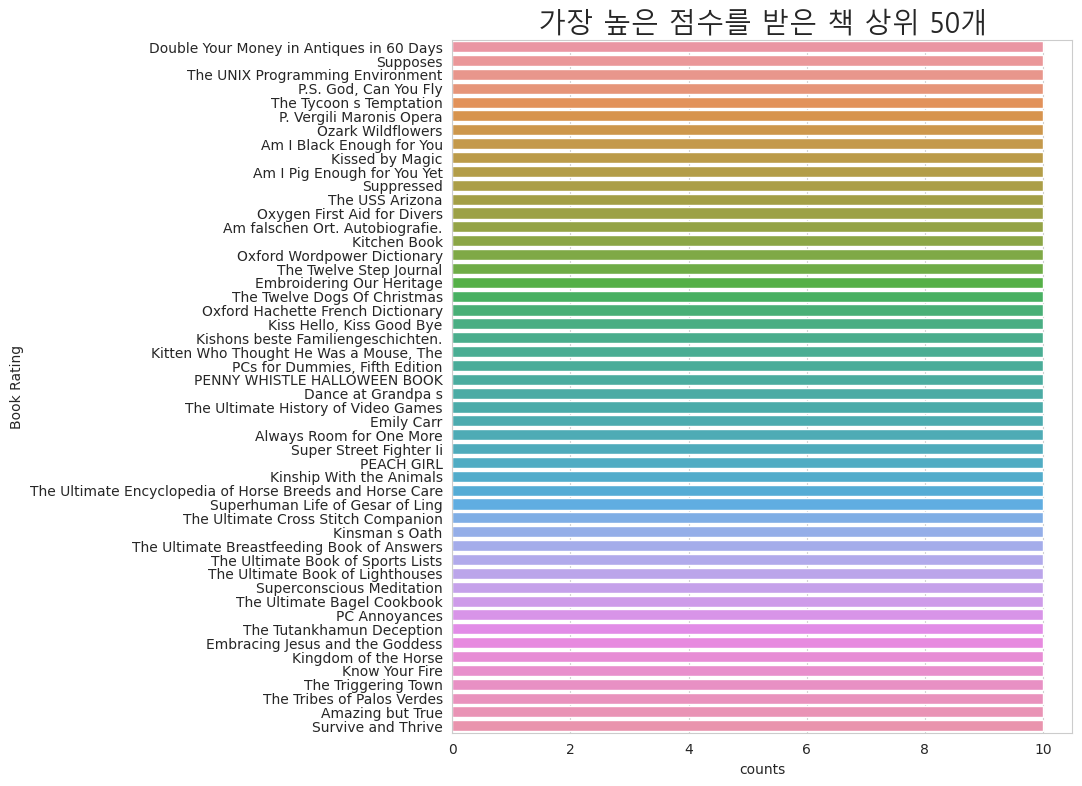

In [88]:
title_counts = train_df.groupby('Main-Title').mean().reset_index()
tc = title_counts[['Main-Title', 'Book-Rating']]
tc = tc.sort_values('Book-Rating', ascending=False).head(50)

plt.figure(figsize=(8, 9))
sns.barplot(data=tc, x='Book-Rating', y='Main-Title')
plt.title('가장 높은 점수를 받은 책 상위 50개', fontproperties=fontprop, size=20)
plt.xlabel('counts')
plt.ylabel('Book Rating')
plt.show()

전부 10점이기 때문에 10점을 제외한 책 평점 시각화

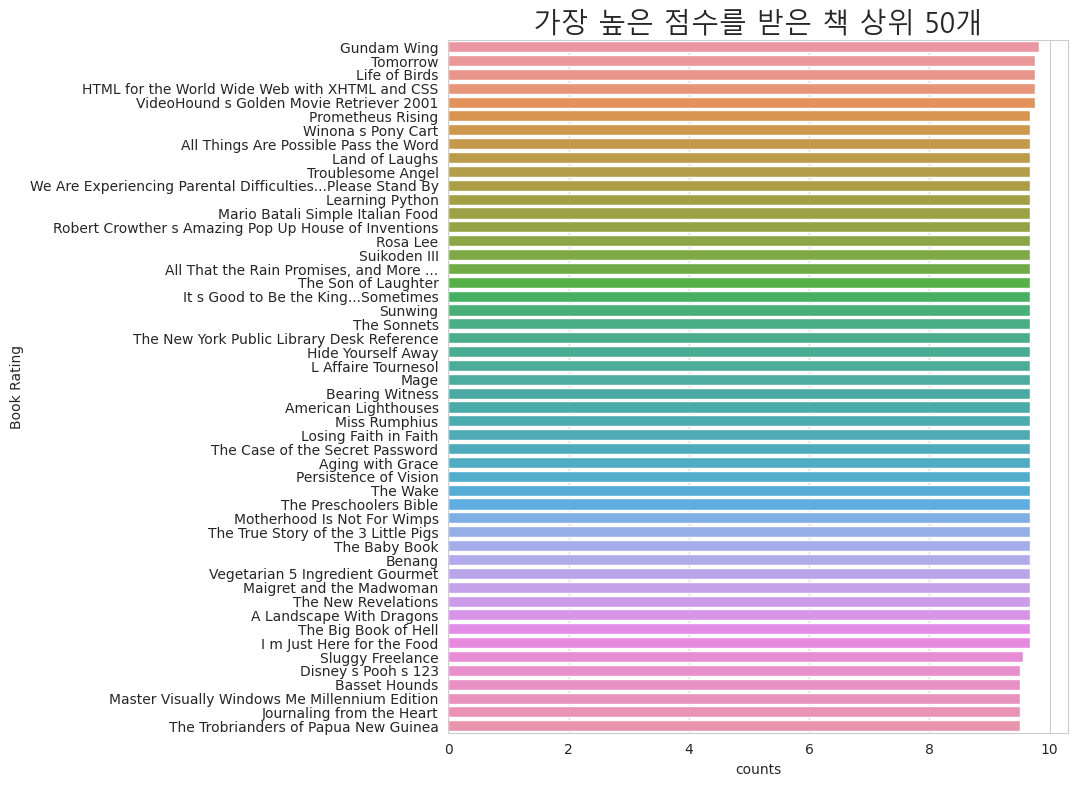

In [89]:
title_counts = train_df.groupby('Main-Title').mean().reset_index()
tc = title_counts[['Main-Title', 'Book-Rating']]
tc = tc[tc['Book-Rating'] != 10.0]
tc = tc.sort_values('Book-Rating', ascending=False).head(50)

plt.figure(figsize=(8, 9))
sns.barplot(data=tc, x='Book-Rating', y='Main-Title')
plt.title('가장 높은 점수를 받은 책 상위 50개', fontproperties=fontprop, size=20)
plt.xlabel('counts')
plt.ylabel('Book Rating')
plt.show()

## 4. Book-Author

In [90]:
train_df

,User-ID,Age,Country,City,Book-ID,Main-Title,Sub-Title,Book-Author,Year-Of-Publication,Publisher,Book-Rating
0,USER_00000,20,canada,sackville,BOOK_044368,Road Taken,No_SUB,Rona Jaffe,2001.0,Mira,8
1,USER_00000,20,canada,sackville,BOOK_081205,Macbeth,New Penguin Shakespeare,William Shakespeare,1981.0,Penguin Books,8
2,USER_00000,20,canada,sackville,BOOK_086781,Waverley,Penguin English Library,Walter Scott,1981.0,Penguin Books,0
3,USER_00000,20,canada,sackville,BOOK_098622,Mother Earth Father Sky,No_SUB,Sue Harrison,1991.0,Avon,0
4,USER_00000,20,canada,sackville,BOOK_180810,She Who Remembers,No_SUB,Linda Lay Shuler,1989.0,Signet Book,8
...,...,...,...,...,...,...,...,...,...,...,...
836036,USER_92096,30,usa,minneapolis,BOOK_081138,Healing Words,The Power of Prayer and the Practice of Medicine,Larry Dossey,1993.0,Harpercollins,0
836037,USER_92097,30,usa,temple,BOOK_258124,The Salmon of Doubt,Hitchhiking the Galaxy One Last Time,DOUGLAS ADAMS,2002.0,Harmony,0
836038,USER_92098,40,canada,ottawa,BOOK_071848,Harry Potter and the Prisoner of Azkaban,Book 3,J. K. Rowling,2000.0,Thorndike Press,0
836039,USER_92099,40,usa,maple grove,BOOK_252599,Heartbreak Hill,Anatomy of a Ryder Cup,Tim Rosaforte,1996.0,St Martins Pr,8


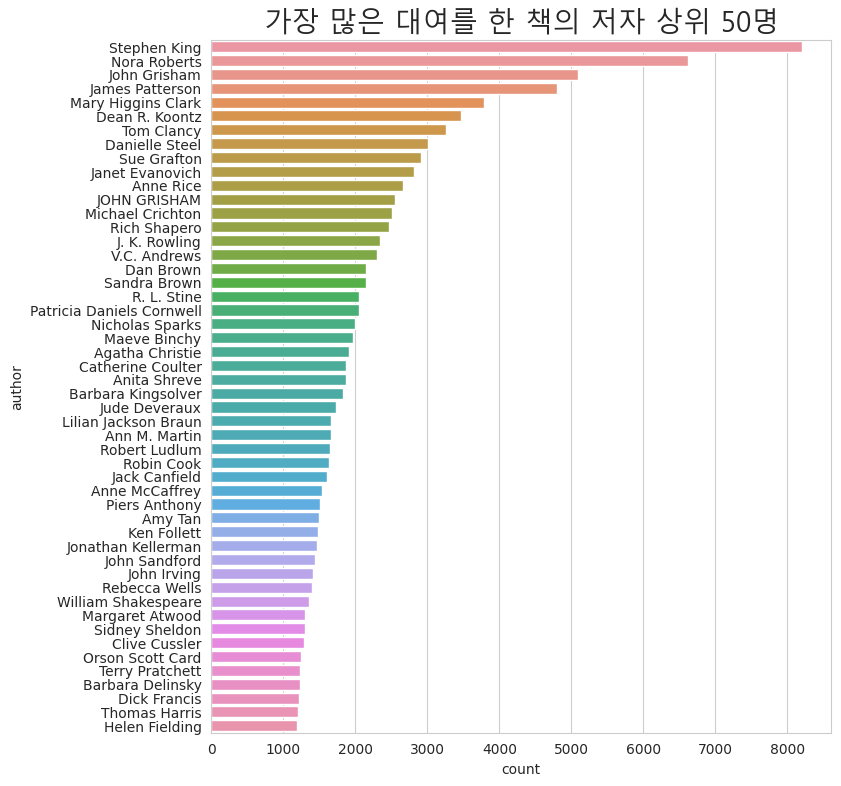

In [91]:
ds = train_df['Book-Author'].value_counts().reset_index()
ds.columns = ['author', 'count']
ds = ds.sort_values('count', ascending=False).head(50)

plt.figure(figsize=(8, 9))
sns.barplot(x='count', y='author', data=ds, orient='h')
plt.title('가장 많은 대여를 한 책의 저자 상위 50명', fontproperties=fontprop, size=20)
plt.show()

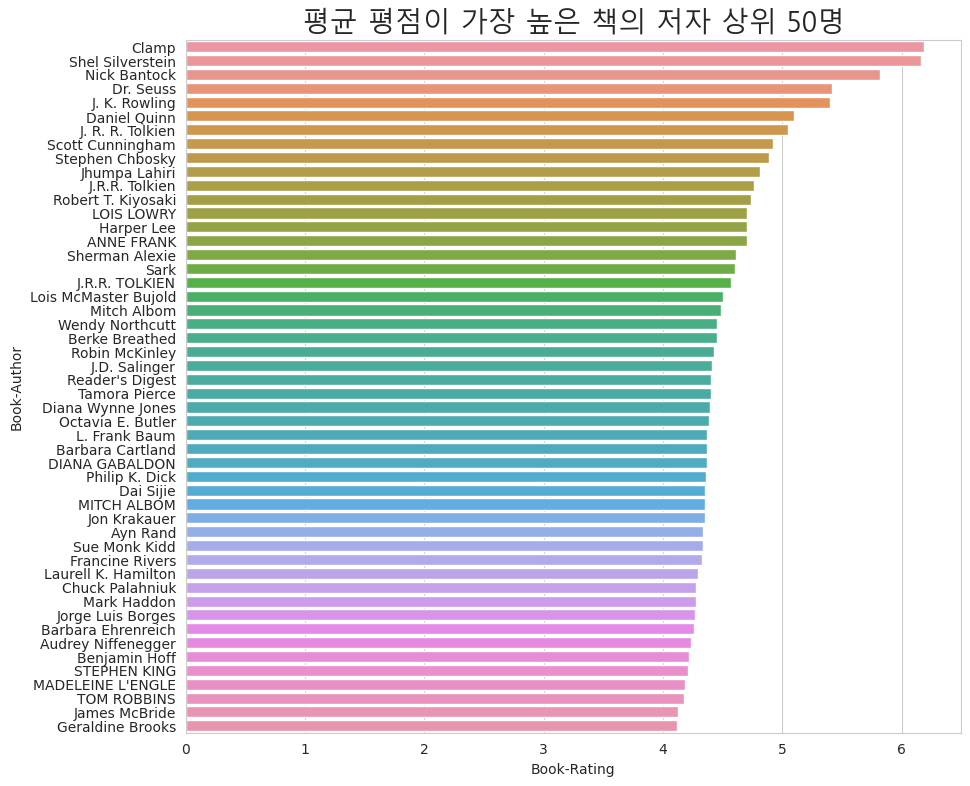

In [92]:
books = train_df['Book-Author'].value_counts().reset_index()
books.columns = ['Book-Author', 'author_evaluation_count']
temp_df = pd.merge(temp_df, books)

mean_df = temp_df[temp_df['author_evaluation_count']>100]
mean_df = mean_df.groupby('Book-Author')['Book-Rating'].mean().reset_index().sort_values('Book-Rating', ascending=False)

top_50_mean_df = mean_df.head(50)

plt.figure(figsize=(10,9))
sns.barplot(x='Book-Rating', y='Book-Author', data=top_50_mean_df, orient='h')
plt.title('평균 평점이 가장 높은 책의 저자 상위 50명', fontproperties=fontprop, size=20)
plt.show()

## 5. Year

In [93]:
train_df['Year-Of-Publication'].unique()

array([ 2.001e+03,  1.981e+03,  1.991e+03,  1.989e+03,  1.995e+03,
        1.982e+03,  2.002e+03,  1.993e+03,  1.999e+03,  2.000e+03,
        1.992e+03,  1.998e+03,  1.996e+03,  1.997e+03,  2.003e+03,
        1.990e+03,  1.975e+03,  1.987e+03,  2.004e+03,  1.988e+03,
        1.986e+03,  1.983e+03,  1.978e+03,  1.994e+03,  1.976e+03,
       -1.000e+00,  1.979e+03,  1.985e+03,  1.971e+03,  1.969e+03,
        1.980e+03,  1.972e+03,  1.984e+03,  1.970e+03,  1.974e+03,
        1.959e+03,  1.953e+03,  1.966e+03,  1.965e+03,  1.977e+03,
        1.968e+03,  1.973e+03,  2.021e+03,  1.967e+03,  1.943e+03,
        1.952e+03,  1.930e+03,  1.964e+03,  1.961e+03,  1.956e+03,
        1.946e+03,  1.960e+03,  1.958e+03,  1.941e+03,  1.955e+03,
        1.963e+03,  1.947e+03,  1.950e+03,  1.957e+03,  1.923e+03,
        1.962e+03,  1.954e+03,  2.005e+03,  1.927e+03,  1.942e+03,
        1.949e+03,  1.920e+03,  1.948e+03,  1.940e+03,  1.901e+03,
        1.929e+03,  1.951e+03,  2.011e+03,  2.020e+03,  1.911e

In [94]:
train_df[train_df['Year-Of-Publication'] == -1]

,User-ID,Age,Country,City,Book-ID,Main-Title,Sub-Title,Book-Author,Year-Of-Publication,Publisher,Book-Rating
181,USER_00049,30,usa,gaylord,BOOK_121460,Bxc Blue Bay Mystery,No_SUB,Gertrude Cha Warner,-1.0,Scholastic Inc,0
183,USER_00049,30,usa,gaylord,BOOK_175661,Lighthouse Mystery,No_SUB,Gertrude C Warner,-1.0,Scholastic Inc,10
188,USER_00049,30,usa,gaylord,BOOK_230275,Mike s Mystery,No_SUB,Gertrude Cha Warner,-1.0,Scholastic Inc,0
228,USER_00054,40,usa,spring,BOOK_122689,Charming Billy,No_SUB,Alice Mcdermott,-1.0,"Farrar, Straus Giroux",0
287,USER_00060,20,usa,los angeles,BOOK_165427,Moon Palace,No_SUB,Paul Auster,-1.0,Faber Faber Inc,0
...,...,...,...,...,...,...,...,...,...,...,...
835351,USER_92056,30,usa,leucadia,BOOK_093874,High Ground,No_SUB,John Mcgahern,-1.0,Faber Faber Inc,5
835402,USER_92058,20,canada,halifax,BOOK_117063,Hotel Du Lac,No_SUB,Anita Brookner,-1.0,Penguin Putnam~trade,0
835427,USER_92058,20,canada,halifax,BOOK_181486,Laurels Kitchen a Handbook for Vegetarian Co,No_SUB,Laurel Robertson,-1.0,Bantam Doubleday Dell,8
835544,USER_92080,30,usa,brookhaven,BOOK_045027,Best of Sisters In Crime,No_SUB,Marilyn Wallace,-1.0,Penguin Putnam~childrens Hc,10


Bxc Blue Bay Mystery : 출판 년도 1990

Charming Billy : 출판 년도 1997

즉, -1은 결측값 제거 대상

In [95]:
delete_year = train_df[train_df['Year-Of-Publication'] == -1]
train_df.drop(delete_year.index, inplace=True)

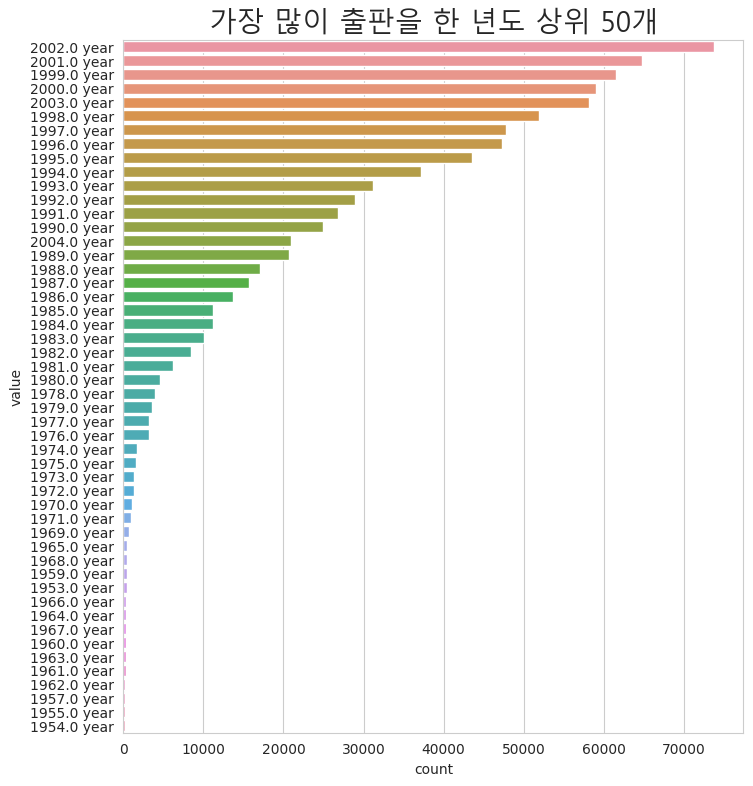

In [96]:
ds = train_df['Year-Of-Publication'].value_counts().reset_index()
ds.columns = ['value', 'count']
ds['value'] = ds['value'].astype(str) + ' year'
ds = ds.sort_values('count', ascending=False).head(50)

plt.figure(figsize=(8, 9))
sns.barplot(data=ds, x='count', y='value', orient='h')
plt.title('가장 많이 출판을 한 년도 상위 50개', fontproperties=fontprop, size=20)
plt.show()

In [97]:
train_df['Year-Of-Publication'] = pd.cut(train_df['Year-Of-Publication'], bins=[-np.inf, 1799, 1899, 1949, 1999, 2009, 2019, np.inf],
                                                                                                              labels=['-1800', '1800s', '1900-1949', '1950-1999', '2000-2009', '2010-2019', '2020+'], right=False)

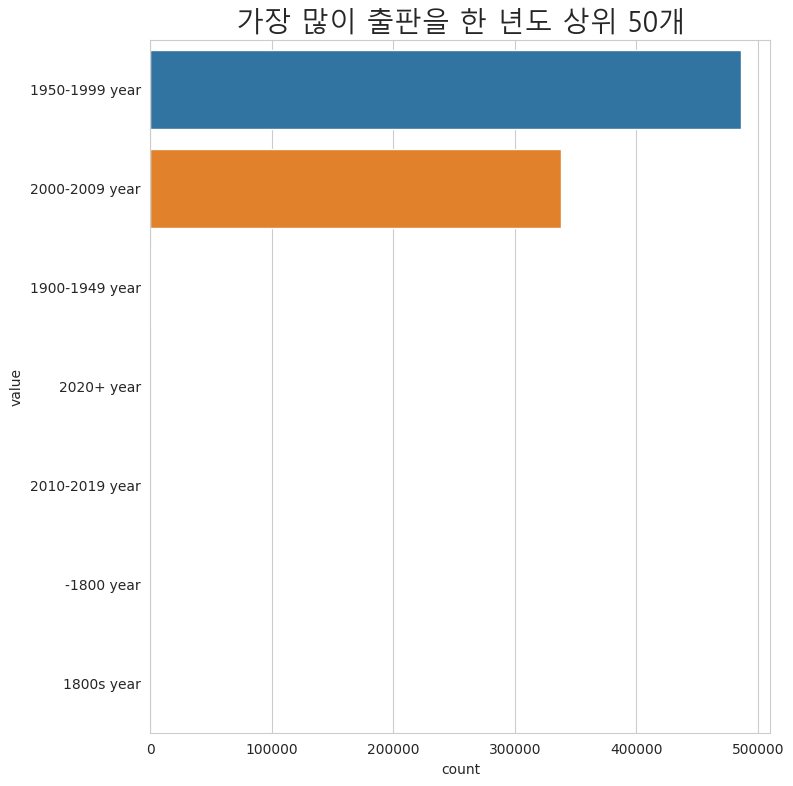

In [98]:
ds = train_df['Year-Of-Publication'].value_counts().reset_index()
ds.columns = ['value', 'count']
ds['value'] = ds['value'].astype(str) + ' year'
ds = ds.sort_values('count', ascending=False).head(50)

plt.figure(figsize=(8, 9))
sns.barplot(data=ds, x='count', y='value', orient='h')
plt.title('가장 많이 출판을 한 년도 상위 50개', fontproperties=fontprop, size=20)
plt.show()

## 6. Publisher

In [99]:
train_df

,User-ID,Age,Country,City,Book-ID,Main-Title,Sub-Title,Book-Author,Year-Of-Publication,Publisher,Book-Rating
0,USER_00000,20,canada,sackville,BOOK_044368,Road Taken,No_SUB,Rona Jaffe,2000-2009,Mira,8
1,USER_00000,20,canada,sackville,BOOK_081205,Macbeth,New Penguin Shakespeare,William Shakespeare,1950-1999,Penguin Books,8
2,USER_00000,20,canada,sackville,BOOK_086781,Waverley,Penguin English Library,Walter Scott,1950-1999,Penguin Books,0
3,USER_00000,20,canada,sackville,BOOK_098622,Mother Earth Father Sky,No_SUB,Sue Harrison,1950-1999,Avon,0
4,USER_00000,20,canada,sackville,BOOK_180810,She Who Remembers,No_SUB,Linda Lay Shuler,1950-1999,Signet Book,8
...,...,...,...,...,...,...,...,...,...,...,...
836036,USER_92096,30,usa,minneapolis,BOOK_081138,Healing Words,The Power of Prayer and the Practice of Medicine,Larry Dossey,1950-1999,Harpercollins,0
836037,USER_92097,30,usa,temple,BOOK_258124,The Salmon of Doubt,Hitchhiking the Galaxy One Last Time,DOUGLAS ADAMS,2000-2009,Harmony,0
836038,USER_92098,40,canada,ottawa,BOOK_071848,Harry Potter and the Prisoner of Azkaban,Book 3,J. K. Rowling,2000-2009,Thorndike Press,0
836039,USER_92099,40,usa,maple grove,BOOK_252599,Heartbreak Hill,Anatomy of a Ryder Cup,Tim Rosaforte,1950-1999,St Martins Pr,8


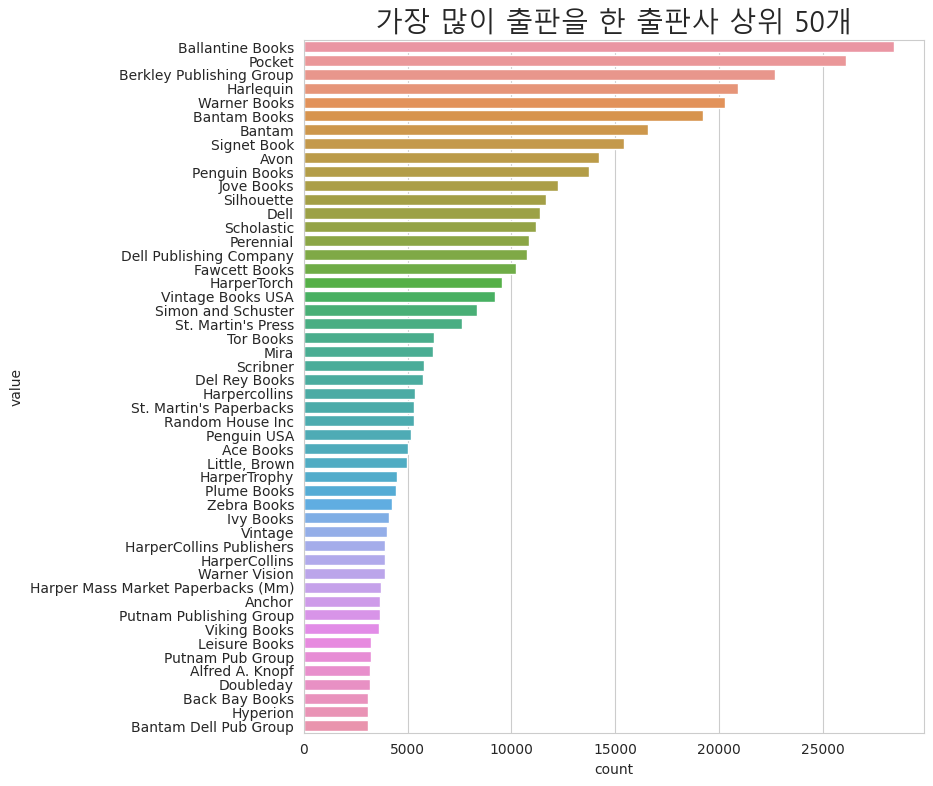

In [100]:
ds = train_df['Publisher'].value_counts().reset_index()
ds.columns = ['value', 'count']
ds = ds.sort_values('count', ascending=False).head(50)

plt.figure(figsize=(8, 9))
sns.barplot(data=ds, x='count', y='value', orient='h')
plt.title('가장 많이 출판을 한 출판사 상위 50개', fontproperties=fontprop, size=20)
plt.show()

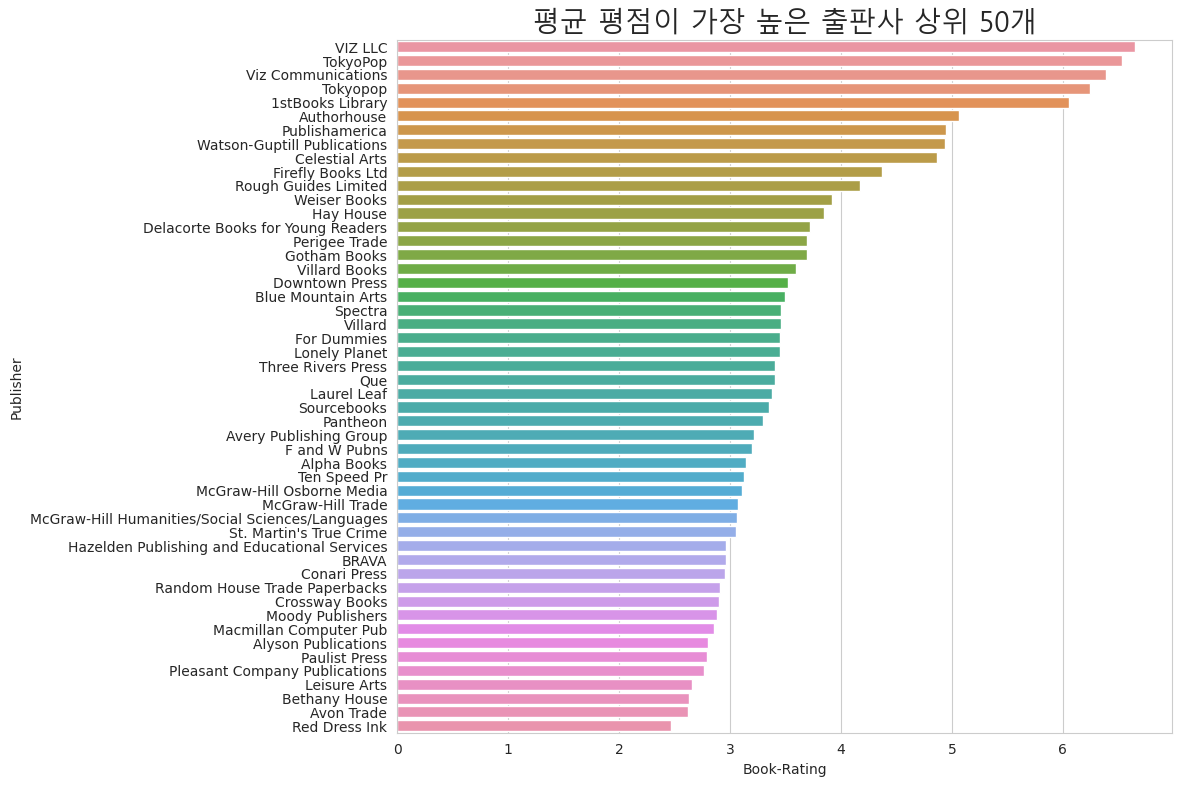

In [101]:
books = temp_df['Publisher'].value_counts().reset_index()
books.columns = ['Publisher', 'Publisher_evaluation_count']
temp_df = pd.merge(temp_df, books)
mean_df = temp_df[temp_df['Publisher_evaluation_count']>100]
mean_df = mean_df.groupby('Publisher')['Book-Rating'].mean().reset_index().sort_values('Book-Rating', ascending=False)

sns.set_style("whitegrid")
plt.figure(figsize=(10, 9))
sns.barplot(x='Book-Rating', y='Publisher', data=mean_df.head(50), orient='h')
plt.title('평균 평점이 가장 높은 출판사 상위 50개', fontproperties=fontprop, size=20)
plt.show()

## 7. Rating

종속 변수 Rating 분포 확인

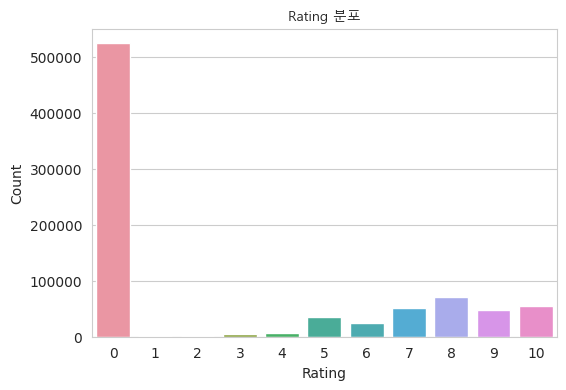

In [102]:
rating = train_df['Book-Rating'].value_counts().reset_index()
rating.columns = ['value', 'count']

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x='value', y='count', data=rating, ax=ax)
ax.set_title('Rating 분포', fontproperties=fontprop)
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
plt.show()

대부분의 점수가 0

In [103]:
temp_df = train_df

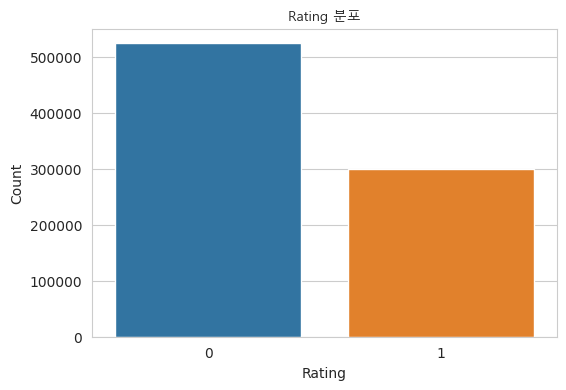

In [104]:
temp_df['Book-Rating_2'] = temp_df['Book-Rating'].map(lambda x: 1 if x != 0 else x)
rating2 = temp_df['Book-Rating_2'].value_counts().reset_index()
rating2.columns = ['value', 'count']

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x='value', y='count', data=rating2, ax=ax)
ax.set_title('Rating 분포', fontproperties=fontprop)
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
plt.show()

1점 ~ 10점을 모두 더해도 0점 보다 적다.

## 8. Word Cloud

In [105]:
from wordcloud import WordCloud, STOPWORDS

stop_words=set(STOPWORDS)
cross_title_string = " ".join(train_df['Main-Title'].astype(str))

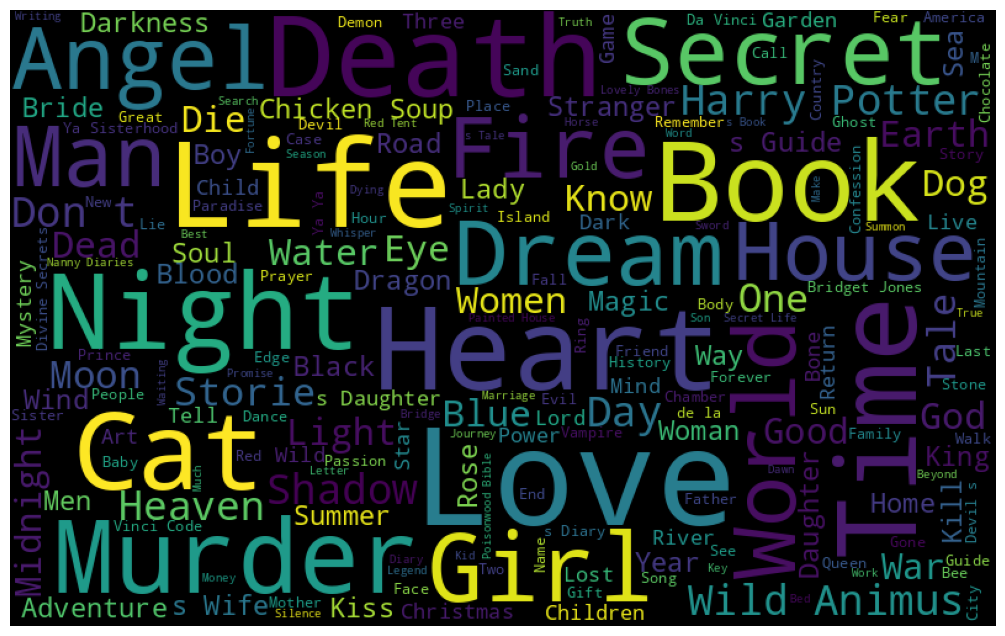

In [106]:
def wordcloud(string):
    wc = WordCloud(width=800,height=500,mask=None,random_state=21, max_font_size=110,stopwords=stop_words).generate(string)
    fig=plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(wc)

wordcloud(cross_title_string)

In [108]:
df = train_df.drop(columns = ['Book-ID', 'Book-Rating_2'])
df

,User-ID,Age,Country,City,Main-Title,Sub-Title,Book-Author,Year-Of-Publication,Publisher,Book-Rating
0,USER_00000,20,canada,sackville,Road Taken,No_SUB,Rona Jaffe,2000-2009,Mira,8
1,USER_00000,20,canada,sackville,Macbeth,New Penguin Shakespeare,William Shakespeare,1950-1999,Penguin Books,8
2,USER_00000,20,canada,sackville,Waverley,Penguin English Library,Walter Scott,1950-1999,Penguin Books,0
3,USER_00000,20,canada,sackville,Mother Earth Father Sky,No_SUB,Sue Harrison,1950-1999,Avon,0
4,USER_00000,20,canada,sackville,She Who Remembers,No_SUB,Linda Lay Shuler,1950-1999,Signet Book,8
...,...,...,...,...,...,...,...,...,...,...
836036,USER_92096,30,usa,minneapolis,Healing Words,The Power of Prayer and the Practice of Medicine,Larry Dossey,1950-1999,Harpercollins,0
836037,USER_92097,30,usa,temple,The Salmon of Doubt,Hitchhiking the Galaxy One Last Time,DOUGLAS ADAMS,2000-2009,Harmony,0
836038,USER_92098,40,canada,ottawa,Harry Potter and the Prisoner of Azkaban,Book 3,J. K. Rowling,2000-2009,Thorndike Press,0
836039,USER_92099,40,usa,maple grove,Heartbreak Hill,Anatomy of a Ryder Cup,Tim Rosaforte,1950-1999,St Martins Pr,8


In [109]:
df.to_csv('./drive/MyDrive/data/book/book_rating_predict_data.csv')